# This notebook is for the Fair-Shapely experiment

In [13]:
%reload_ext autoreload
%autoreload 2

### 1. Import libraries

In [14]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

### 2. Import dataset

In [15]:
from src.data.unified_dataloader import load_dataset

a, processed_german_credit = load_dataset('german_credit')
_, processed_adult = load_dataset('adult')

Age                   0
Sex                   0
Job                   0
Housing               0
Saving accounts     183
Checking account    394
Credit amount         0
Duration              0
Purpose               0
Risk                  0
dtype: int64


In [16]:
processed_adult.head(3)

,age,education-num,capital-gain,capital-loss,hours-per-week,sex,workclass_?,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,...,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia,income
0,0.030671,1.134739,0.148453,-0.21666,-0.035429,1,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
1,0.837109,1.134739,-0.145920,-0.21666,-2.222153,1,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
2,-0.042642,-0.420060,-0.145920,-0.21666,-0.035429,1,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0


### 3. Split label/unlabel data, split train/test data.

In [17]:
'''UCI dataset'''
df = processed_adult.copy()
X = df.drop('income', axis=1)
y = df['income']



# into 70% training and 30% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=25) 
print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')

X_train shape: (22792, 106)
X_test shape: (9769, 106)


### 4. Train the original model

In [18]:
model = XGBClassifier()  # 可以替换为 RandomForestClassifier() 等其他模型
model.fit(X_train,y_train)

# 预测和评估
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.8749104309550619


In [19]:
X_train['sex'].value_counts()

sex
1    15232
0     7560
Name: count, dtype: int64

In [20]:
'''把X_train分成majority和minority两个部分'''

male_condition = X_train['sex'] == 1
X_train_majority = X_train[male_condition]
y_train_majority = y_train[male_condition]

female_condition = X_train['sex'] == 0
X_train_minority = X_train[female_condition]
y_train_minority = y_train[female_condition]

### 5. Evaluate the performance of original model

In [21]:
from src.attribution.oracle_metric import perturb_numpy_ver
from src.attribution import FairnessExplainer
sen_att_name = ["sex"]
sen_att = [X_train.columns.get_loc(name) for name in sen_att_name]
priv_val = [1]
unpriv_dict = [list(set(X_train.values[:, sa])) for sa in sen_att]
for sa_list, pv in zip(unpriv_dict, priv_val):
    sa_list.remove(pv)
# print(f'sen_att_name:{sen_att_name}')
# print(f'sen_att:{sen_att}') # index of sensitive attribute
# print(f'priv_val:{priv_val}') # privileged value
# print(f'unpriv_dict:{unpriv_dict}') # unprivileged value(all values in the sensitive attribute, except the privileged value)



''' 
计算DR value的函数
'''
def fairness_value_function(sen_att, priv_val, unpriv_dict, X, model):
    X_disturbed = perturb_numpy_ver(
        X=X,
        sen_att=sen_att,
        priv_val=priv_val,
        unpriv_dict=unpriv_dict,
        ratio=1.0,
    )
    fx = model.predict_proba(X)[:, 1]
    fx_q = model.predict_proba(X_disturbed)[:, 1]
    return np.mean(np.abs(fx - fx_q))
original_DR = fairness_value_function(sen_att, priv_val, unpriv_dict, X_test.values, model)
print(f'original_DR: {original_DR}')

original_DR: 0.02362159453332424


### 5. 把female和male匹配，（或者male和female匹配），然后进行修改，重新训练

总共可以替换的点数:9114


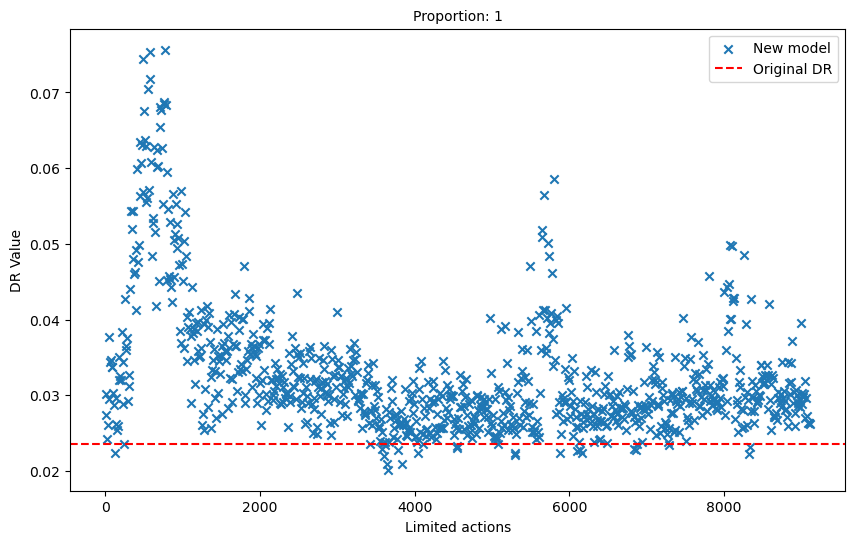

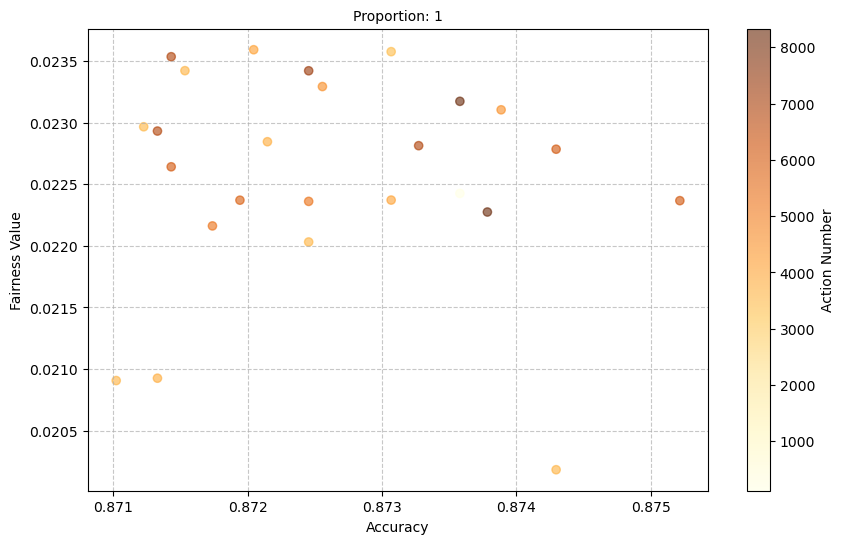

([0.02745255,
  0.030160883,
  0.024216535,
  0.026087455,
  0.029481042,
  0.03775324,
  0.03437938,
  0.034717094,
  0.03369939,
  0.033766888,
  0.03028261,
  0.02869485,
  0.022425547,
  0.029694637,
  0.026230741,
  0.025412625,
  0.026019214,
  0.03196834,
  0.03505656,
  0.032584313,
  0.032055553,
  0.038402904,
  0.028905245,
  0.03445568,
  0.023628851,
  0.042778127,
  0.03604394,
  0.036583517,
  0.037565056,
  0.029243406,
  0.03125204,
  0.032663107,
  0.04404076,
  0.054316364,
  0.051977728,
  0.05435886,
  0.04794921,
  0.04599579,
  0.046273317,
  0.049197048,
  0.04124076,
  0.059947256,
  0.047591742,
  0.049888976,
  0.0633904,
  0.056355968,
  0.060666908,
  0.06305053,
  0.07442993,
  0.056827817,
  0.06752372,
  0.063749164,
  0.062868826,
  0.055525754,
  0.05601088,
  0.07043985,
  0.05707434,
  0.07534667,
  0.071727626,
  0.060797807,
  0.048394013,
  0.05340963,
  0.052717287,
  0.062734604,
  0.051600497,
  0.041768044,
  0.062429506,
  0.060198072,
  0.06

In [22]:
from src.experiments_approach2 import ExperimentNew

''' 改变minority group中的部分特征值'''

experiment = ExperimentNew(
                            model,
                            X_train_majority,
                            y_train_majority,
                            X_train_minority,
                            y_train_minority,
                            X_test,
                            y_test,
                            dataset_name='adult',
                            change_group = 'minority')
experiment.run_experiment()


总共可以替换的点数:26443
但是我们只替换其中的三分之一:8814


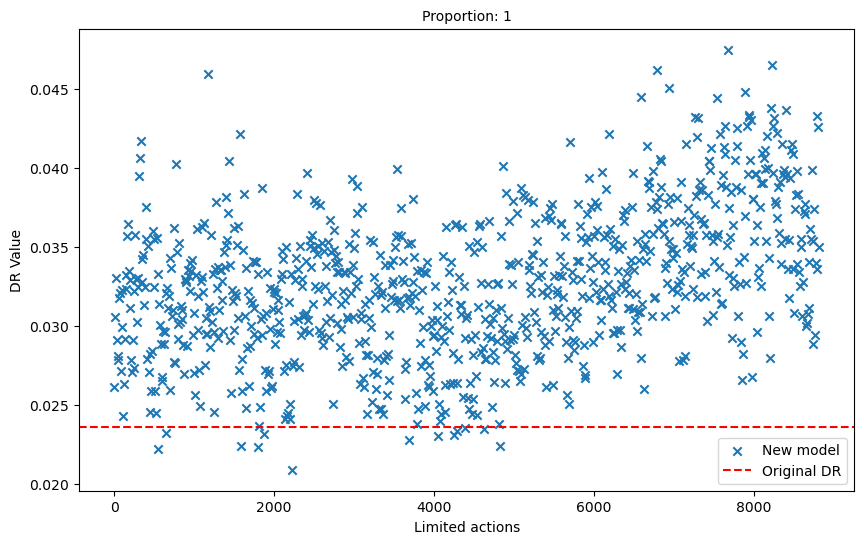

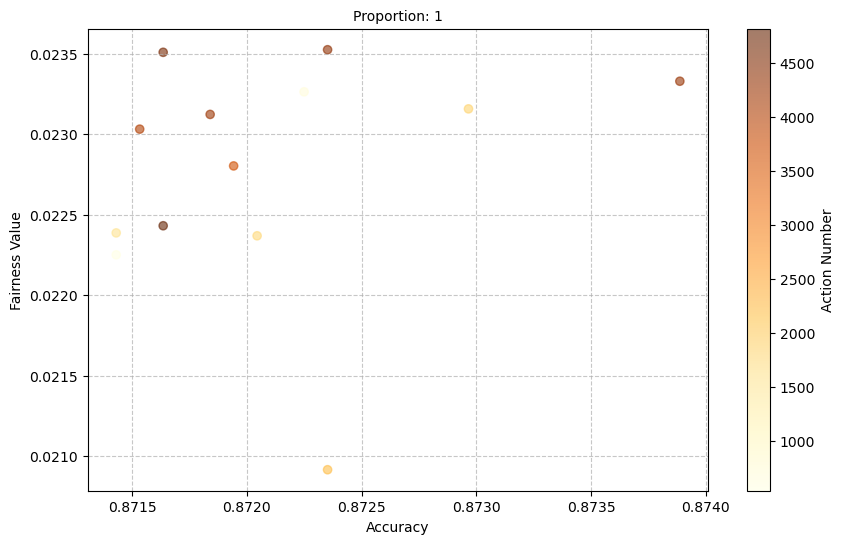

([0.02611709,
  0.030533982,
  0.033055,
  0.029115168,
  0.027873091,
  0.028115945,
  0.031762686,
  0.032083448,
  0.027179547,
  0.029920526,
  0.032239627,
  0.02428372,
  0.026352623,
  0.029159682,
  0.03234294,
  0.03319855,
  0.035711247,
  0.036418017,
  0.033466607,
  0.03113777,
  0.032916844,
  0.027820036,
  0.027067695,
  0.02909838,
  0.027327571,
  0.03218907,
  0.035740085,
  0.032950662,
  0.030256243,
  0.032455727,
  0.033028353,
  0.03947909,
  0.04063397,
  0.04168835,
  0.03275096,
  0.03419709,
  0.034494124,
  0.031329002,
  0.032434408,
  0.0375394,
  0.035478026,
  0.027939565,
  0.035023626,
  0.027080195,
  0.028204193,
  0.024531063,
  0.02589103,
  0.028428676,
  0.03600093,
  0.032478016,
  0.0355126,
  0.025874829,
  0.024508659,
  0.035531834,
  0.022251032,
  0.03330359,
  0.03140409,
  0.030058678,
  0.028884333,
  0.026744472,
  0.02651651,
  0.029706711,
  0.028884983,
  0.029632758,
  0.032070618,
  0.02326461,
  0.03241039,
  0.031119846,
  0.03

In [23]:
''' 改变majority group中的部分特征值'''
experiment2 = ExperimentNew(
                            model,
                            X_train_majority,
                            y_train_majority,
                            X_train_minority,
                            y_train_minority,
                            X_test,
                            y_test,
                            dataset_name='adult',
                            change_group = 'majority')
experiment2.run_experiment()